In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap
import optuna

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

In [3]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
plots_dir = "plots"

In [4]:
# File paths for signal and background root files: 
photon_PU0 = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/photons_0PU_bc_stc_hadd.root"
photon_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered_neutrino.h5"

In [5]:
signal_file = uproot.open(photon_PU0)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
#bg_folder = "l1tHGCalTriggerNtuplizer"
tree_name = "HGCalTriggerNtuple"
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [6]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [7]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']

    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    df = df.copy()  # Avoid modifying original DataFrame
    # Filter to keep only clusters with cl3d_energy > 0
    df = df[df['cl3d_ienergy'] > 0]
    # Compute delta_r
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    # Filter based on delta_r threshold
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    # Sort by event_id, cl3d_energy (descending), delta_r (ascending)
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    # Keep only the first occurrence per event_id
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [8]:
# Function to load and filter the tree data (for ROOT file)
def load_and_filter_tree(tree, filter_pt = 20, eta_range=(1.6, 2.8), cl_pt_threshold=5):
    df_gen = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["gen_n", "gen_eta", "gen_phi", "gen_pt", 
                     "genpart_exeta", "genpart_exphi", "event"]
    ))
    df_cl3d = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["*cl3d*", "event"]
    ))
    df_gen_filtered = df_gen[(df_gen['gen_pt'] > filter_pt) & 
                     (abs(df_gen['gen_eta']) > eta_range[0]) & 
                     (abs(df_gen['gen_eta']) < eta_range[1])]
    df_cl3d_filtered = df_cl3d[(abs(df_cl3d['cl3d_eta']) > eta_range[0]) & 
                     (abs(df_cl3d['cl3d_eta']) < eta_range[1]) &
                     (df_cl3d['cl3d_pt'] > cl_pt_threshold)]
    merged_df = pd.merge(
        df_gen_filtered,
        df_cl3d_filtered,
        on="event",
        how="inner",  # Keep only rows where the event ID exists in both
        suffixes=('_gen', '_cl3d')  # Differentiate common column names
    )
    return merged_df

In [9]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [10]:
photonPU0_df = load_and_filter_tree(signal_tree)

In [11]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [12]:
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [13]:
photonPU0_df_filtered = filter_by_delta_r(photonPU0_df)

In [14]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [15]:
photonPU0_df_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,delta_r
0,1,2,2.483386,2.098612,54.209084,2.098623,2.485730,2,2988204837,50.260590,...,16383,8160,8388607,9.521496,31.513376,0.998573,1,51.634308,312.218903,0.001564
1,6,2,2.333653,-2.164097,22.779718,-2.164111,2.341516,2,2988867621,21.364246,...,16383,4064,8388607,9.203490,27.038399,0.991326,1,21.639072,113.552956,0.001216
2,11,2,2.445046,-1.794452,25.749636,-1.794445,2.438145,2,2988872021,22.920778,...,16383,4064,8388607,7.934333,26.502281,0.991326,1,22.956285,132.714050,0.003928
3,15,2,-2.753007,-2.634864,72.960312,-2.634867,-2.750263,2,3123589904,67.934761,...,16383,2046,8388607,8.115665,29.153255,0.998785,1,69.529350,545.782593,0.001040
4,17,2,-1.874361,0.769389,53.100552,0.769377,-1.871578,2,3131877172,48.235130,...,16383,4092,8388607,10.094450,29.023270,0.991326,1,52.801643,175.601334,0.000563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62848,199974,2,2.500853,-2.806144,27.496031,-2.806145,2.494332,2,2987795316,24.713163,...,16383,8064,8388607,10.906770,30.369690,0.998573,1,24.827343,151.685013,0.003174
62849,199975,2,-1.770573,2.513438,85.604301,2.513438,-1.761501,2,3131355987,79.840271,...,16383,8176,8388607,8.294725,28.133316,0.998573,1,88.147057,264.207581,0.001510
62850,199979,2,2.469297,1.258688,30.444538,1.258667,2.460307,2,2988212530,28.673014,...,16383,8128,8388607,7.524310,20.501797,0.987597,1,28.881283,170.473450,0.004496
62851,199984,2,1.694931,1.645395,61.279842,1.645386,1.696400,2,3005556018,55.947704,...,16383,8160,8388607,8.921800,27.249767,0.998573,1,62.960518,177.558380,0.000612


In [16]:
photonPU200_df_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,delta_r
0,5,2,-2.497891,2.115998,27.981705,2.116029,-2.505429,118,3123470422,33.445847,...,8190,1020,458753,10.236671,33.615051,0.888885,3,27.652697,170.324997,0.001004
1,6,2,-2.236405,-2.093659,42.773136,-2.093663,-2.230369,121,3122566210,48.754372,...,4093,2032,2437120,8.962974,34.870506,0.826003,2,44.652100,210.569412,0.003194
2,7,2,2.723982,1.690832,50.737434,1.690848,2.736200,162,2988204628,64.273796,...,8191,4092,3620864,13.252326,55.226467,0.998785,3,59.776356,464.643707,0.004327
3,8,2,2.459304,1.091641,58.898102,1.091647,2.447088,212,2988728391,66.147903,...,8191,4088,2424832,10.151257,42.801365,0.998573,3,62.515568,363.659790,0.002859
4,12,2,-1.676072,0.761729,71.171089,0.761740,-1.677965,46,3139225974,69.402634,...,8191,4088,2097152,11.684155,36.620708,0.998573,3,76.393753,211.907043,0.002024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91676,299981,2,2.528172,2.382890,42.980457,2.382893,2.510117,197,2987680850,52.985542,...,8189,4064,3605504,14.216464,54.313652,0.992695,3,48.723251,302.257843,0.009305
91677,299991,2,2.301080,-0.435585,28.195385,-0.435576,2.292806,144,2988856595,33.108803,...,4092,2016,1048576,8.552400,30.275141,0.980927,3,30.000563,150.518723,0.003898
91678,299992,2,2.695126,-0.928240,20.297224,-0.928248,2.685960,178,2988864343,32.808548,...,8188,4064,296960,17.543015,55.048004,-0.991529,0,26.311922,190.963791,0.019876
91679,299994,2,2.029385,-0.861808,22.579664,-0.861812,2.021904,194,2997270069,24.605637,...,8191,2016,2097152,7.440147,20.975151,0.998573,3,22.853653,87.894409,0.004009


In [17]:
neutrinoPU200_df_20GeV = neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [18]:
def plot_delta_r_3d_two_dfs(df, label, eta_col='cl3d_eta', energy_col='cl3d_energy', delta_r_col='delta_r', 
                            colors=('blue', 'red'), cmap = 'plasma', figsize=(12, 8)):
    # Ensure required columns are present
    required_columns = [eta_col, delta_r_col, energy_col]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Create the plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        df[eta_col], df[delta_r_col], c=df[energy_col], cmap=cmap, alpha=0.7, edgecolor='k', s=20
    )
    cbar = plt.colorbar(scatter, label=f"Energy [GeV]")
    # Set axis labels and title
    plt.xlabel("$\eta$ [rad]")
    plt.ylabel("$\Delta$ R [rad]")
    plt.title(f"$\Delta$ R vs $\eta$ for {label}")
    plt.tight_layout()
    filename = os.path.join(plots_dir,f"delta_r_vs_etaenergy_{label.replace(' ', '_')}.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved plot as: {filename}")
    plt.show()

Saved plot as: plots/delta_r_vs_etaenergy_photon_PU0.png


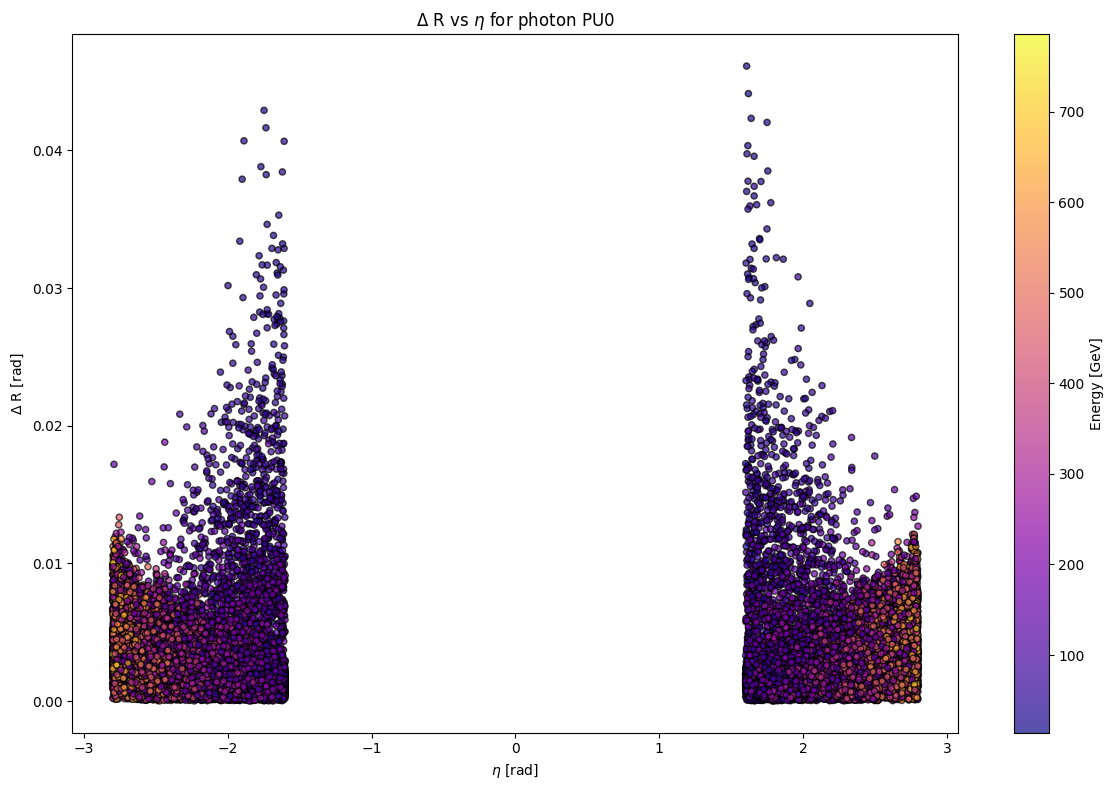

In [19]:
plot_delta_r_3d_two_dfs(photonPU0_df_filtered, 'photon PU0', colors=('blue', 'red'))

Saved plot as: plots/delta_r_vs_etaenergy_photon_PU200.png


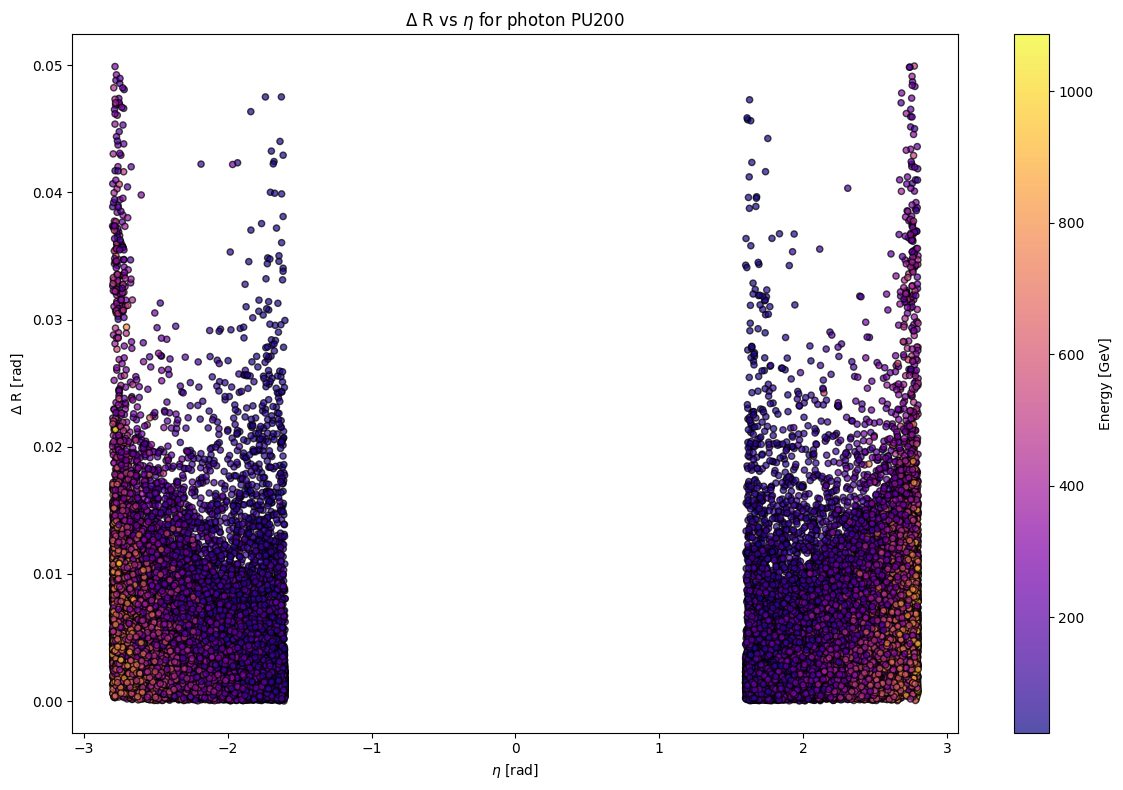

In [20]:
plot_delta_r_3d_two_dfs(photonPU200_df_filtered, 'photon PU200', colors=('blue', 'red'))

In [21]:
def plot_histograms(df_photon_no_pu, df_photon_pu200, df_neutrino_pu200, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    df_photon_no_pu_filtered = df_photon_no_pu[(df_photon_no_pu['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_no_pu['cl3d_pt'] <= cl3d_pt_range[1])]
    df_photon_pu200_filtered = df_photon_pu200[(df_photon_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    df_neutrino_pu200_filtered = df_neutrino_pu200[(df_neutrino_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_neutrino_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_photon_no_pu_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(
                df_photon_no_pu_filtered[var].min(),
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_no_pu_filtered[var].max(),
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(
                df_photon_no_pu_filtered[var].min(),
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_no_pu_filtered[var].max(),
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        plt.hist(df_photon_no_pu_filtered[var], bins=bin_edges, color='g', histtype='step', linewidth=1.5, label='Photon (0 PU)', density = True)
        plt.hist(df_photon_pu200_filtered[var], bins=bin_edges, color='b', histtype='step', linewidth=1.5, label='Photon (200 PU)', density = True)
        plt.hist(df_neutrino_pu200_filtered[var], bins=bin_edges, color='r', histtype='step', linewidth=1.5, label='Neutrino (200 PU)', density = True)
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()
        plt.tight_layout()
        filename = os.path.join(plots_dir,f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

def plot_roc_curve(fpr, tpr, saveas): # function to plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    filename = os.path.join(plots_dir,f"{saveas}.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    plt.close()

In [22]:
variables = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
       'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr',
       'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers']

Saved: plots/cl3d_pt_histogram_cl3d_pt_20_100.png


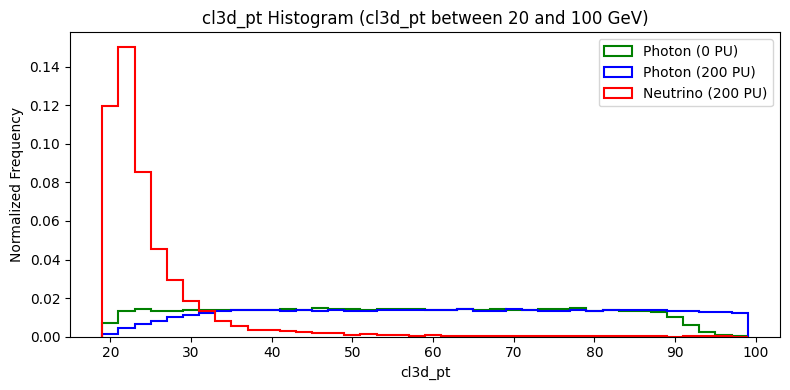

Saved: plots/cl3d_energy_histogram_cl3d_pt_20_100.png


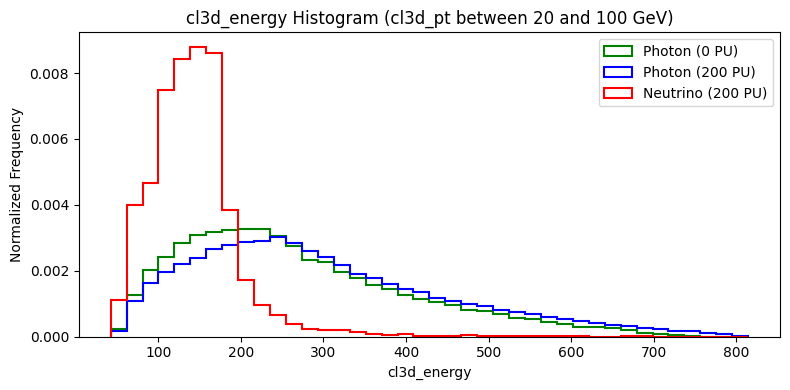

Saved: plots/cl3d_eta_histogram_cl3d_pt_20_100.png


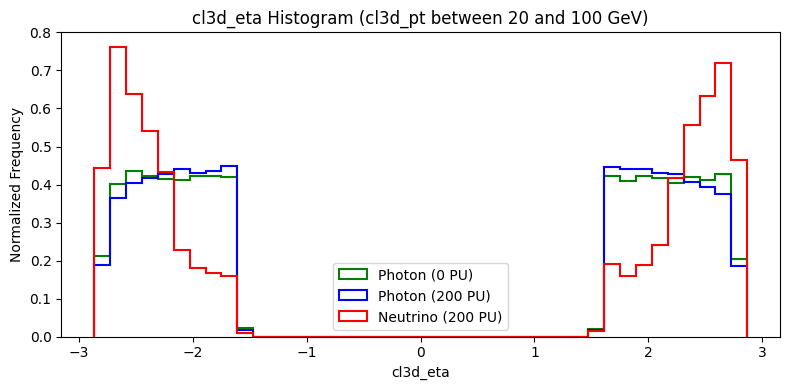

Saved: plots/cl3d_emax1layers_histogram_cl3d_pt_20_100.png


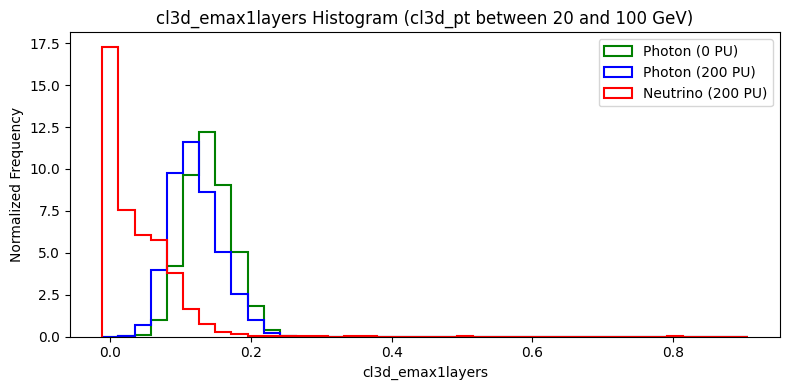

Saved: plots/cl3d_emax3layers_histogram_cl3d_pt_20_100.png


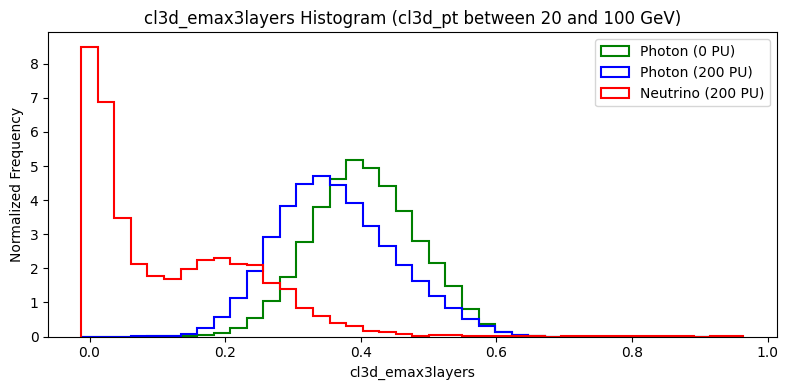

Saved: plots/cl3d_phi_histogram_cl3d_pt_20_100.png


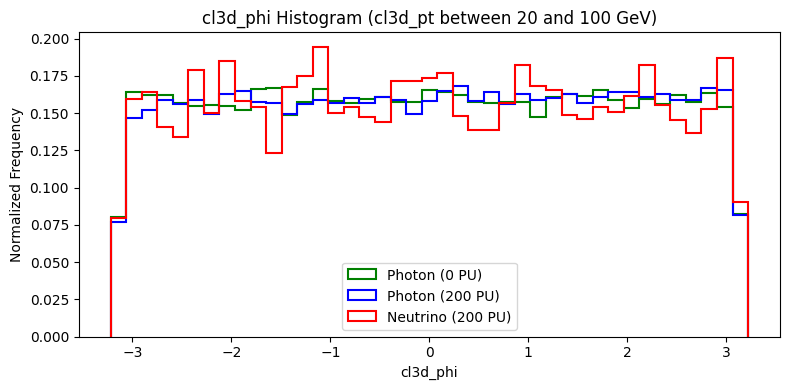

Saved: plots/cl3d_showerlength_histogram_cl3d_pt_20_100.png


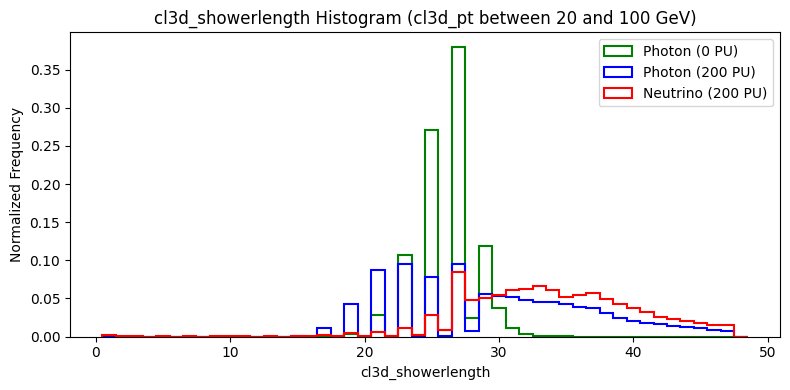

Saved: plots/cl3d_coreshowerlength_histogram_cl3d_pt_20_100.png


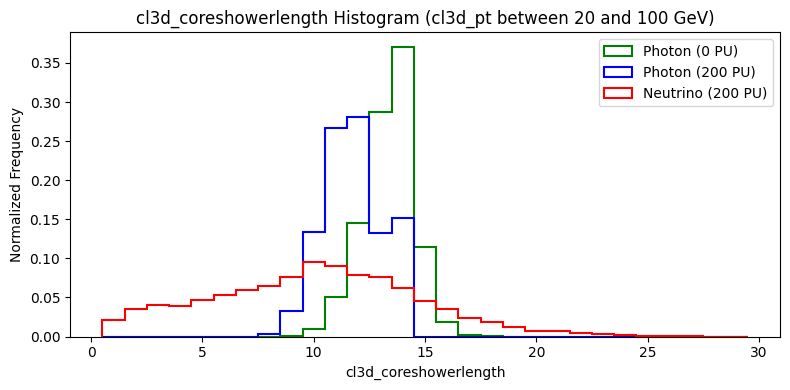

Saved: plots/cl3d_firstlayer_histogram_cl3d_pt_20_100.png


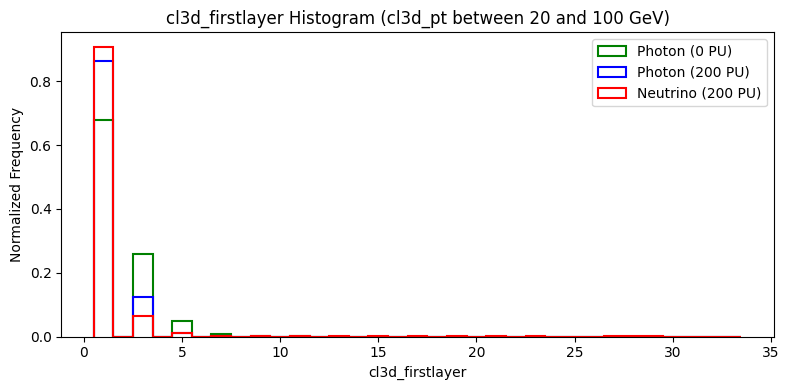

Saved: plots/cl3d_maxlayer_histogram_cl3d_pt_20_100.png


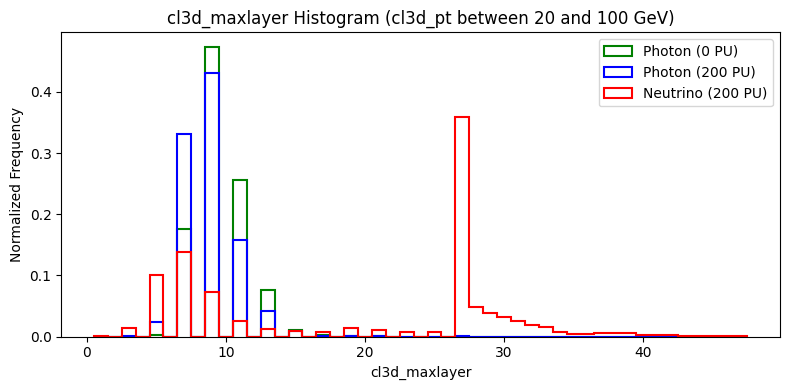

Saved: plots/cl3d_seetot_histogram_cl3d_pt_20_100.png


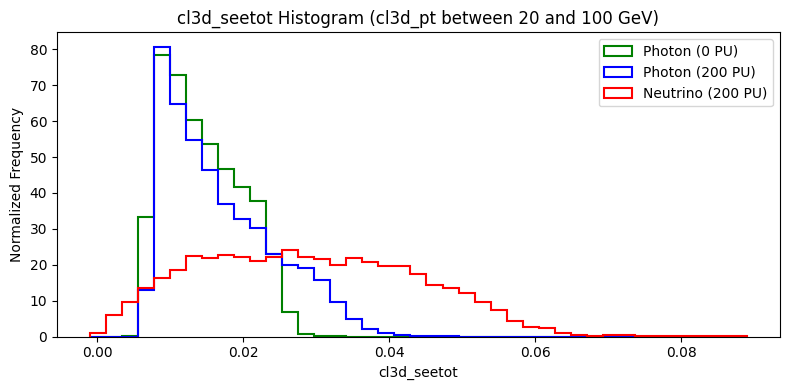

Saved: plots/cl3d_seemax_histogram_cl3d_pt_20_100.png


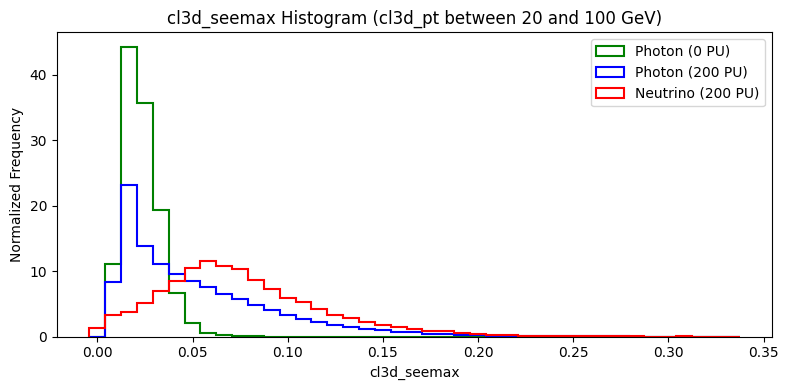

Saved: plots/cl3d_spptot_histogram_cl3d_pt_20_100.png


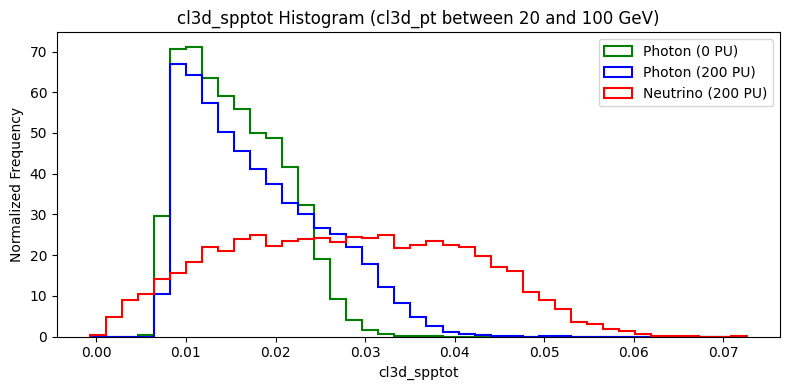

Saved: plots/cl3d_sppmax_histogram_cl3d_pt_20_100.png


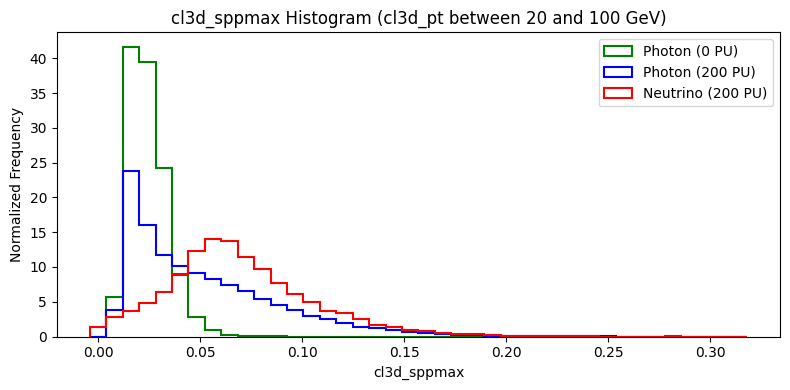

Saved: plots/cl3d_szz_histogram_cl3d_pt_20_100.png


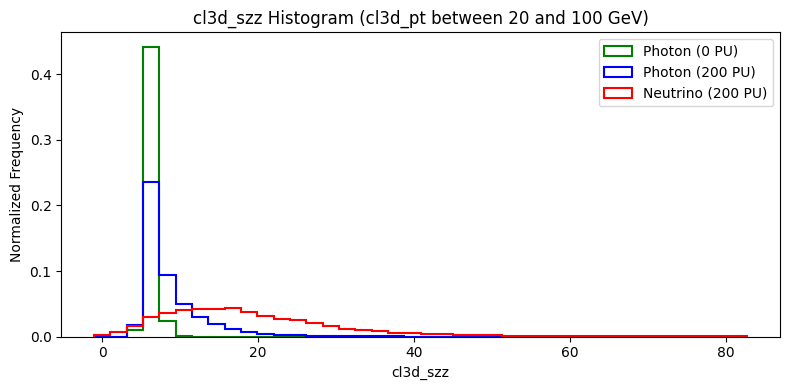

Saved: plots/cl3d_srrtot_histogram_cl3d_pt_20_100.png


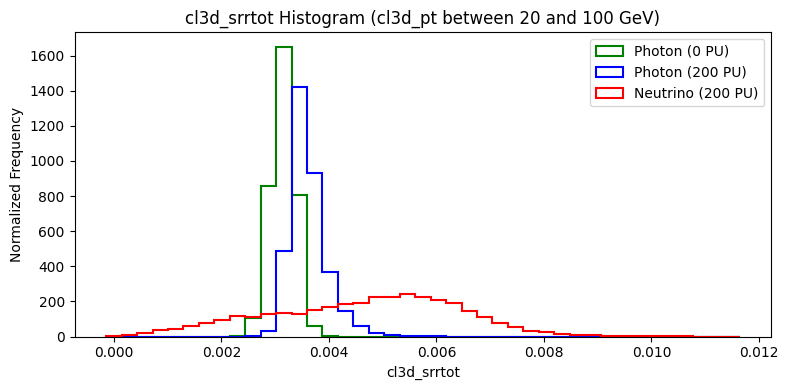

Saved: plots/cl3d_srrmax_histogram_cl3d_pt_20_100.png


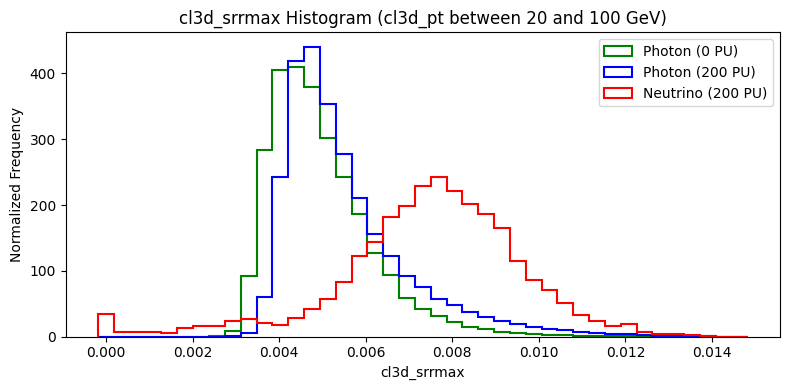

Saved: plots/cl3d_srrmean_histogram_cl3d_pt_20_100.png


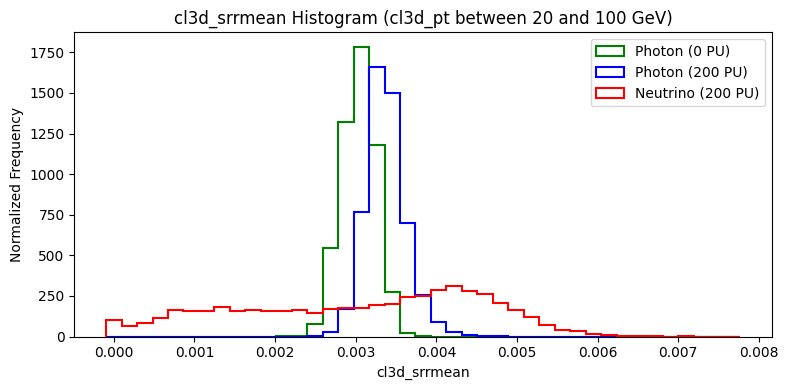

Saved: plots/cl3d_varrr_histogram_cl3d_pt_20_100.png


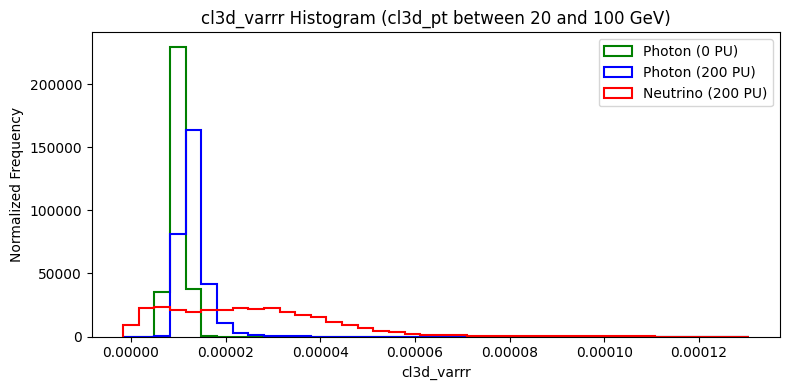

Saved: plots/cl3d_varzz_histogram_cl3d_pt_20_100.png


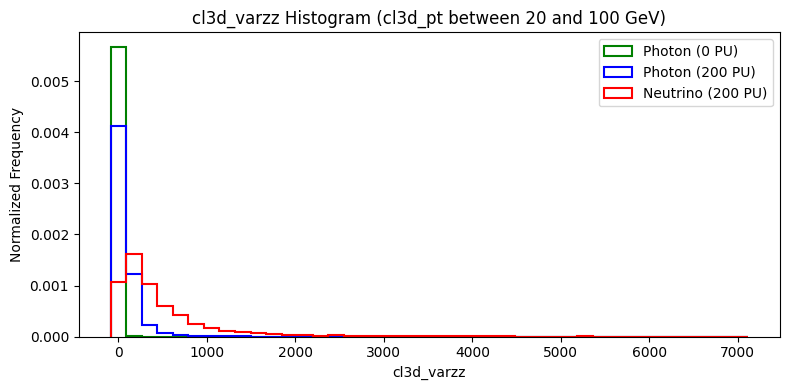

Saved: plots/cl3d_varee_histogram_cl3d_pt_20_100.png


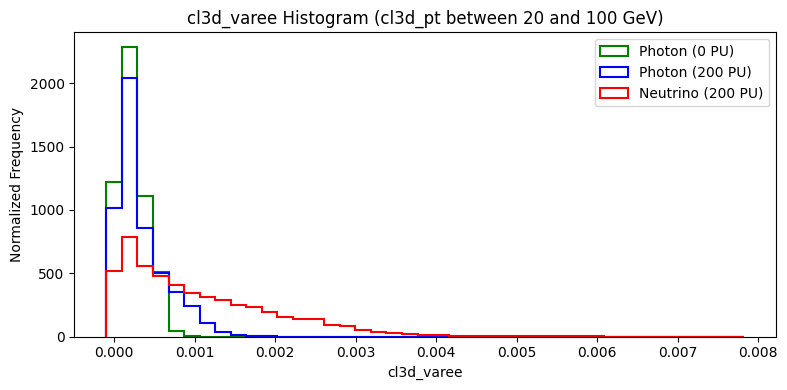

Saved: plots/cl3d_varpp_histogram_cl3d_pt_20_100.png


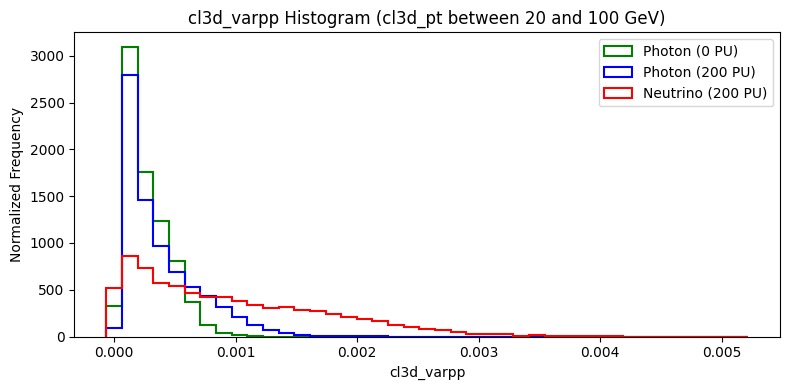

Saved: plots/cl3d_emaxe_histogram_cl3d_pt_20_100.png


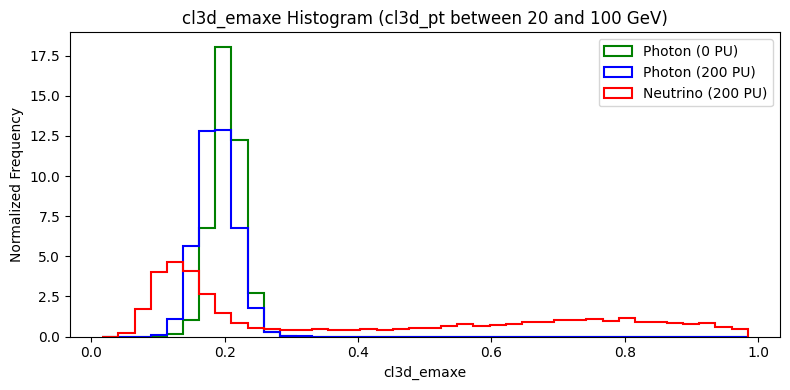

Saved: plots/cl3d_hoe_histogram_cl3d_pt_20_100.png


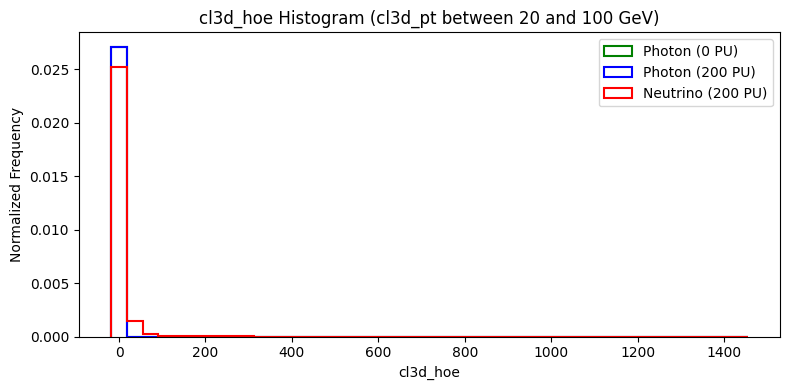

Saved: plots/cl3d_meanz_histogram_cl3d_pt_20_100.png


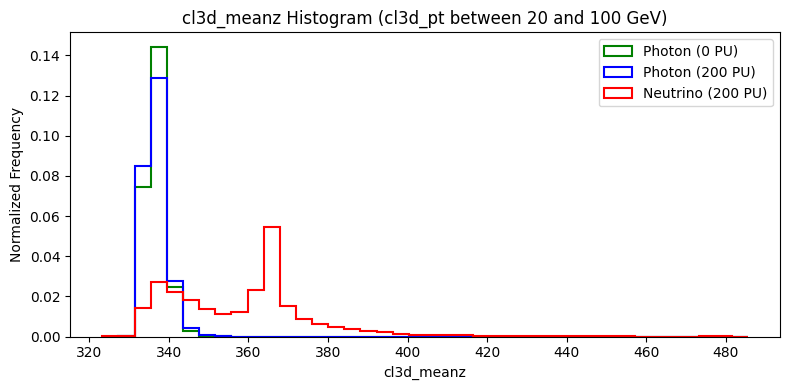

Saved: plots/cl3d_layer10_histogram_cl3d_pt_20_100.png


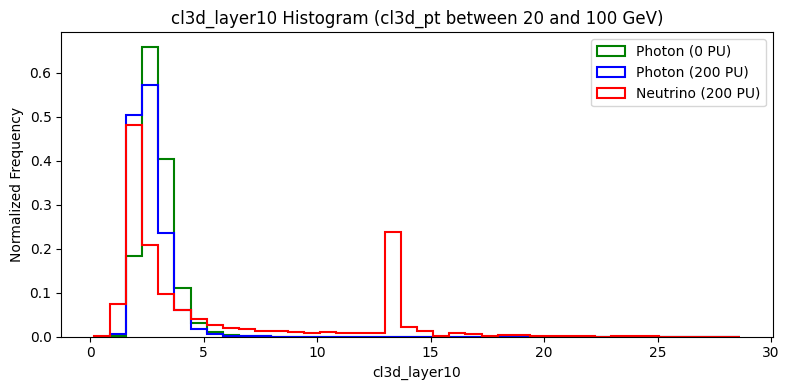

Saved: plots/cl3d_layer50_histogram_cl3d_pt_20_100.png


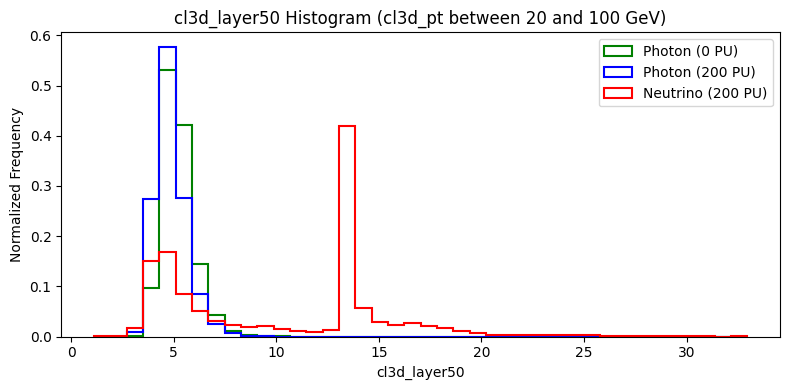

Saved: plots/cl3d_layer90_histogram_cl3d_pt_20_100.png


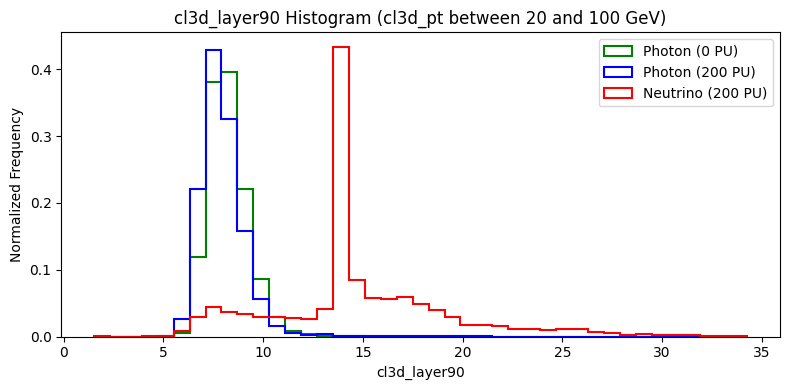

Saved: plots/cl3d_first1layers_histogram_cl3d_pt_20_100.png


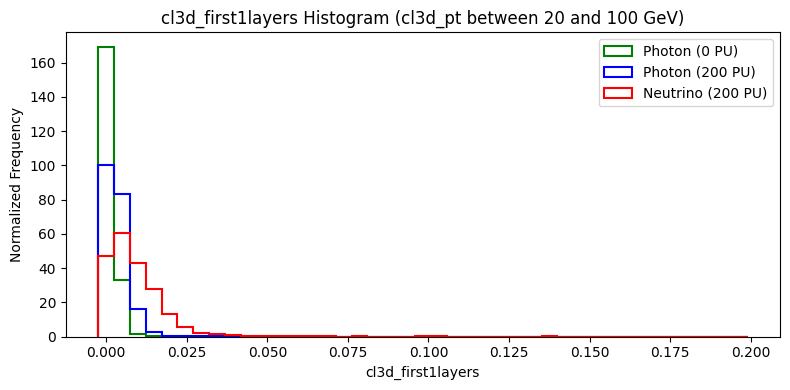

Saved: plots/cl3d_first3layers_histogram_cl3d_pt_20_100.png


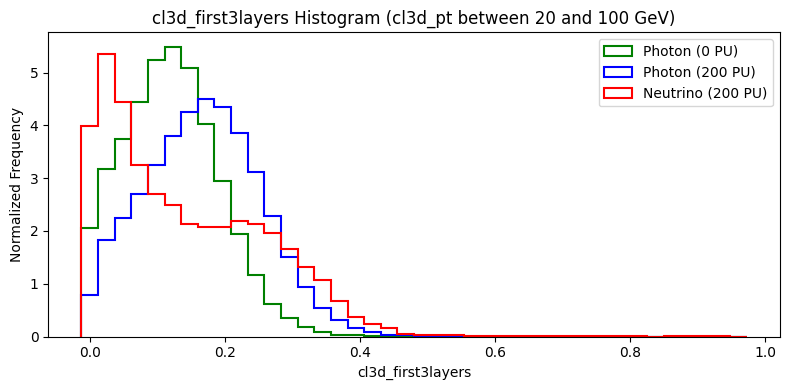

Saved: plots/cl3d_first5layers_histogram_cl3d_pt_20_100.png


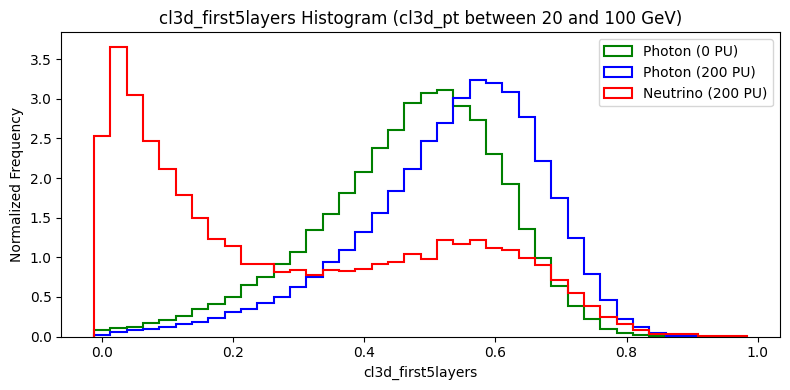

Saved: plots/cl3d_firstHcal1layers_histogram_cl3d_pt_20_100.png


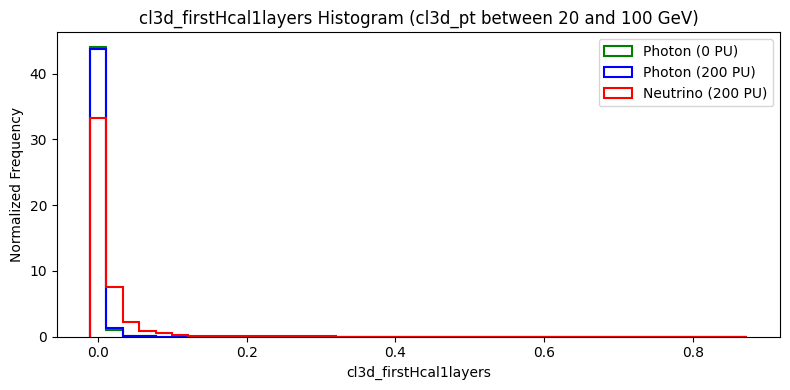

Saved: plots/cl3d_firstHcal3layers_histogram_cl3d_pt_20_100.png


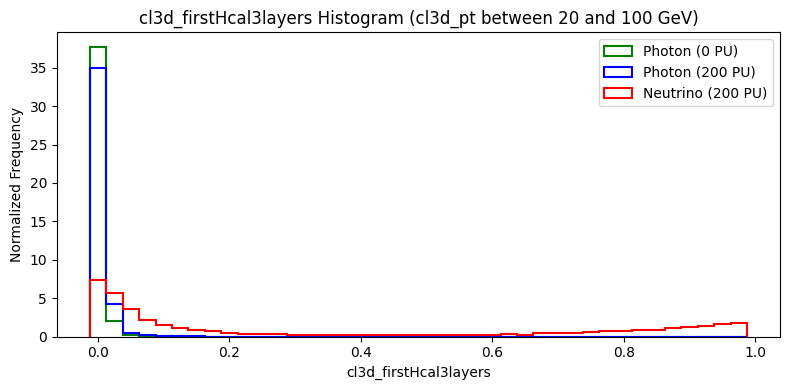

Saved: plots/cl3d_firstHcal5layers_histogram_cl3d_pt_20_100.png


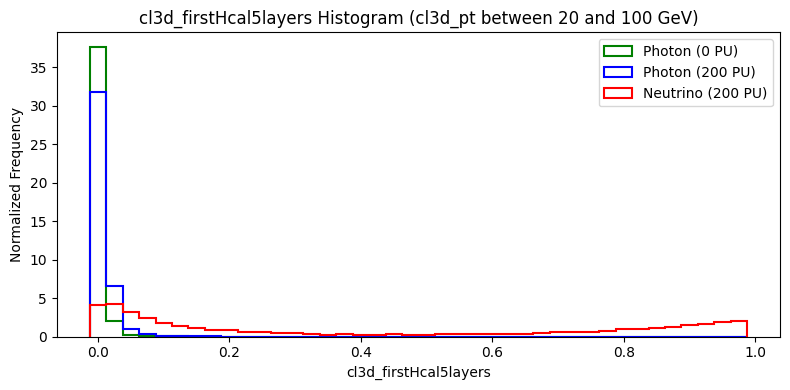

Saved: plots/cl3d_last1layers_histogram_cl3d_pt_20_100.png


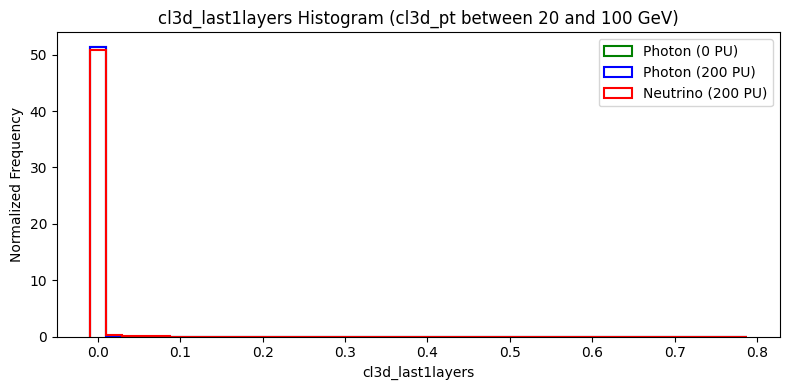

Saved: plots/cl3d_last3layers_histogram_cl3d_pt_20_100.png


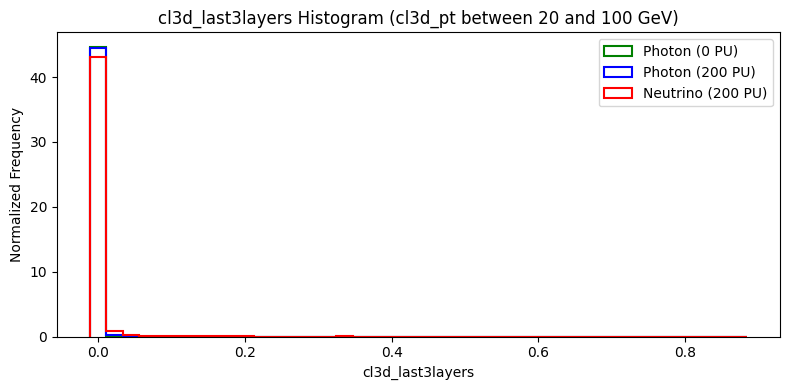

Saved: plots/cl3d_last5layers_histogram_cl3d_pt_20_100.png


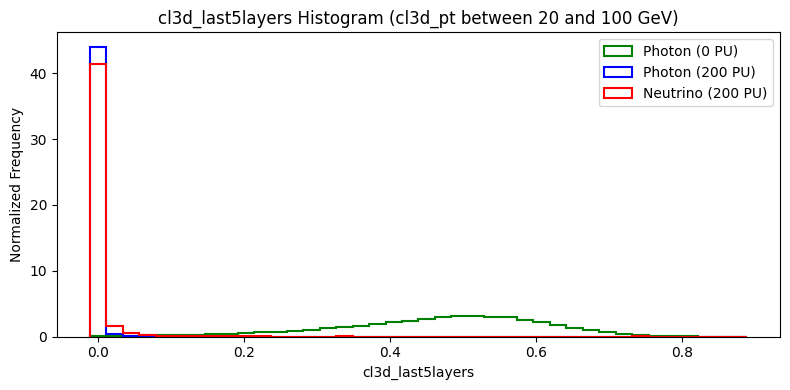

In [23]:
plot_histograms(photonPU0_df_filtered, photonPU200_df_filtered, neutrinoPU200_df_20GeV, variables, cl3d_pt_range=(20, 100))

In [24]:
# Get the common columns between signal and background DataFrames
common_columns = photonPU200_df_filtered.columns.intersection(neutrinoPU200_df_20GeV.columns)

# Keep only the common columns in both DataFrames
neutrinoPU200_df_final = neutrinoPU200_df_20GeV[common_columns]
photonPU200_df_final = photonPU200_df_filtered[common_columns]
photonPU0_df_final = photonPU0_df_filtered[common_columns]

In [25]:
# Assign class labels
neutrinoPU200_df_final['label'] = 0  # Neutrino background
photonPU200_df_final['label'] = 1    # Photon signal with PU=200
photonPU0_df_final['label'] = 2      # Photon signal with PU=0 (if included)

# Combine datasets
df_combined = pd.concat([neutrinoPU200_df_final, photonPU200_df_final, photonPU0_df_final], ignore_index=True)

/tmp/ipykernel_283405/1003149032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photonPU200_df_final['label'] = 1    # Photon signal with PU=200
/tmp/ipykernel_283405/1003149032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photonPU0_df_final['label'] = 2      # Photon signal with PU=0 (if included)


In [26]:
'''
pt_bins = [20, 30, 40, 50]  # Example bins
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)'''

columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

In [27]:
#filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
filtered_data = df_combined[columns_for_training + ['label']].copy()
feature_importance_by_bin = {}
shap_values_by_bin = {}
mean_shap_values = {}

In [28]:
X = filtered_data[columns_for_training]
y = filtered_data['label']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
def objective(trial, X_train, y_train, X_test, y_test):
    """
    Optuna objective function to optimize XGBoost hyperparameters while keeping memory usage optimized.
    """
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": trial.suggest_int("max_depth", 1, 4),  # Reduced max depth
        "learning_rate": trial.suggest_float:q
        log=True),  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Evaluate using AUC
    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

In [40]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=300, n_jobs=1)
print(f"Best parameters: {study.best_params}")

[I 2025-02-04 15:08:30,006] A new study created in memory with name: no-name-fca504ca-f949-4faa-8984-5e8b721977c0
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:08:33,176] Trial 0 finished with value: 0.9843120106920781 and parameters: {'max_depth': 2, 'learning_rate': 0.004813968866603262, 'gamma': 2.07202573288682, 'reg_lambda': 8.682652935069427, 'reg_alpha': 0.8078117210237035}. Best is trial 0 with value: 0.9843120106920781.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:08:35,105] Trial 1 finished with value: 0

[I 2025-02-04 15:09:18,538] Trial 14 finished with value: 0.9885849863234842 and parameters: {'max_depth': 3, 'learning_rate': 0.0010151201719556001, 'gamma': 0.12957734121346026, 'reg_lambda': 5.495582149964003, 'reg_alpha': 3.3583881486903335}. Best is trial 10 with value: 0.9946496005106134.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:09:19,766] Trial 15 finished with value: 0.9903643235377811 and parameters: {'max_depth': 1, 'learning_rate': 0.021898309386991593, 'gamma': 1.189954187856469, 'reg_lambda': 3.6698325442214554, 'reg_alpha': 0.6174430502320368}. Best is trial 10 with value: 0.9946496005106134.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.p

[I 2025-02-04 15:10:32,051] Trial 29 finished with value: 0.9938635065070012 and parameters: {'max_depth': 3, 'learning_rate': 0.01903155611602942, 'gamma': 0.5094644027436237, 'reg_lambda': 4.376311345843421, 'reg_alpha': 4.809084784498399}. Best is trial 23 with value: 0.996859567975992.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:10:35,770] Trial 30 finished with value: 0.9947795871947274 and parameters: {'max_depth': 4, 'learning_rate': 0.013303231967038828, 'gamma': 2.0699017234689085, 'reg_lambda': 2.5382769528115254, 'reg_alpha': 2.050937906233272}. Best is trial 23 with value: 0.996859567975992.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395

[I 2025-02-04 15:20:42,390] Trial 44 finished with value: 0.9963626876564108 and parameters: {'max_depth': 2, 'learning_rate': 0.04146668237666293, 'gamma': 4.949727569286278, 'reg_lambda': 9.854214740910185, 'reg_alpha': 4.6034670311780665}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:21:10,178] Trial 45 finished with value: 0.9888482164474255 and parameters: {'max_depth': 3, 'learning_rate': 0.003401473120642461, 'gamma': 4.373226410041751, 'reg_lambda': 8.76113959216401, 'reg_alpha': 4.614873790383011}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395:

[I 2025-02-04 15:30:32,814] Trial 59 finished with value: 0.9968350069437298 and parameters: {'max_depth': 4, 'learning_rate': 0.03714912912908711, 'gamma': 3.343846375704132, 'reg_lambda': 9.459046018357032, 'reg_alpha': 4.9947663427278}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:31:25,807] Trial 60 finished with value: 0.9965085255937364 and parameters: {'max_depth': 4, 'learning_rate': 0.02681139194377531, 'gamma': 4.679464052555345, 'reg_lambda': 5.6053581566827635, 'reg_alpha': 3.946528878140172}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: U

[I 2025-02-04 15:40:04,589] Trial 74 finished with value: 0.9970497782086885 and parameters: {'max_depth': 4, 'learning_rate': 0.04411729662979025, 'gamma': 3.2681996353646943, 'reg_lambda': 7.337897047709227, 'reg_alpha': 4.384625100483291}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:40:08,214] Trial 75 finished with value: 0.9938018492169716 and parameters: {'max_depth': 4, 'learning_rate': 0.004565690108607075, 'gamma': 3.024093742646651, 'reg_lambda': 6.9771447439598075, 'reg_alpha': 3.647820043010068}. Best is trial 36 with value: 0.9973800625778964.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:139

[I 2025-02-04 15:41:15,000] Trial 89 finished with value: 0.9973759023247795 and parameters: {'max_depth': 4, 'learning_rate': 0.04881731547194348, 'gamma': 4.008607243610983, 'reg_lambda': 6.329086342955635, 'reg_alpha': 0.7969626254516132}. Best is trial 87 with value: 0.9973830437989397.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:41:18,379] Trial 90 finished with value: 0.9974011890384671 and parameters: {'max_depth': 4, 'learning_rate': 0.0491420106435305, 'gamma': 4.372378579644997, 'reg_lambda': 6.385024095108657, 'reg_alpha': 0.8746579521915905}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395:

[I 2025-02-04 15:42:10,641] Trial 104 finished with value: 0.9973676138574613 and parameters: {'max_depth': 4, 'learning_rate': 0.04947423897789354, 'gamma': 4.081741639102662, 'reg_lambda': 6.11028877439699, 'reg_alpha': 0.5761909750031822}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:42:14,600] Trial 105 finished with value: 0.9968028655041719 and parameters: {'max_depth': 4, 'learning_rate': 0.0380420309046986, 'gamma': 4.423045578812746, 'reg_lambda': 6.176221682912661, 'reg_alpha': 0.45271371185336384}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:139

[I 2025-02-04 15:43:12,922] Trial 119 finished with value: 0.9968974027307511 and parameters: {'max_depth': 4, 'learning_rate': 0.036267569837732314, 'gamma': 4.346203065984897, 'reg_lambda': 6.987879300028226, 'reg_alpha': 0.5262655178018727}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:43:16,930] Trial 120 finished with value: 0.9920304560516565 and parameters: {'max_depth': 4, 'learning_rate': 0.0019899610645377815, 'gamma': 4.036399614541876, 'reg_lambda': 4.973222842187469, 'reg_alpha': 0.6876347192091794}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py

[I 2025-02-04 15:44:10,385] Trial 134 finished with value: 0.9971370810482538 and parameters: {'max_depth': 4, 'learning_rate': 0.04521785867531825, 'gamma': 3.571651853250258, 'reg_lambda': 6.231515409090618, 'reg_alpha': 1.4250312998831158}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:44:14,222] Trial 135 finished with value: 0.9971064342240817 and parameters: {'max_depth': 4, 'learning_rate': 0.04232281249193694, 'gamma': 3.342891448624107, 'reg_lambda': 6.659175744061936, 'reg_alpha': 1.114536056936041}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:139

[I 2025-02-04 15:45:16,657] Trial 149 finished with value: 0.9973869845854885 and parameters: {'max_depth': 4, 'learning_rate': 0.04973423590387552, 'gamma': 4.212372311926177, 'reg_lambda': 5.865638965944119, 'reg_alpha': 2.500517446269757}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:45:33,807] Trial 150 finished with value: 0.9970088741258694 and parameters: {'max_depth': 4, 'learning_rate': 0.040789600936655505, 'gamma': 4.212081505515902, 'reg_lambda': 5.207024705404211, 'reg_alpha': 2.6874179674131864}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:13

[I 2025-02-04 15:46:49,771] Trial 164 finished with value: 0.9972540839620523 and parameters: {'max_depth': 4, 'learning_rate': 0.046447047504488775, 'gamma': 3.735538627644944, 'reg_lambda': 4.575670339433611, 'reg_alpha': 0.937350121091257}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:46:58,150] Trial 165 finished with value: 0.9973756187803816 and parameters: {'max_depth': 4, 'learning_rate': 0.049767365185845854, 'gamma': 3.9714271006471638, 'reg_lambda': 6.074837076797228, 'reg_alpha': 1.0213752914176513}. Best is trial 90 with value: 0.9974011890384671.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:

[I 2025-02-04 15:47:59,487] Trial 179 finished with value: 0.9971798578056562 and parameters: {'max_depth': 4, 'learning_rate': 0.045564915378405305, 'gamma': 0.5094225555794191, 'reg_lambda': 1.48949735505209, 'reg_alpha': 1.3968518010014996}. Best is trial 176 with value: 0.9974193470935604.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:48:03,585] Trial 180 finished with value: 0.9968501949913999 and parameters: {'max_depth': 4, 'learning_rate': 0.03527600845899964, 'gamma': 0.8635929773035983, 'reg_lambda': 2.8140117252369694, 'reg_alpha': 1.5449263602872099}. Best is trial 176 with value: 0.9974193470935604.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:49:15,301] Trial 194 finished with value: 0.9973957376170746 and parameters: {'max_depth': 4, 'learning_rate': 0.0499323856548205, 'gamma': 0.24182241757709794, 'reg_lambda': 3.5791594469871035, 'reg_alpha': 1.447541902883683}. Best is trial 176 with value: 0.9974193470935604.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:49:19,899] Trial 195 finished with value: 0.9973944240215584 and parameters: {'max_depth': 4, 'learning_rate': 0.04990044563231049, 'gamma': 0.0878052

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:50:15,575] Trial 209 finished with value: 0.9971085311710705 and parameters: {'max_depth': 4, 'learning_rate': 0.04156937103279391, 'gamma': 0.2321378911281387, 'reg_lambda': 3.7271810600768056, 'reg_alpha': 1.5038670867395934}. Best is trial 176 with value: 0.9974193470935604.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:50:18,275] Trial 210 finished with value: 0.9963630785311741 and parameters: {'max_depth': 2, 'learning_rate': 0.045958852153928836, 'gamma': 0.07699

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:51:33,775] Trial 224 finished with value: 0.9970623054244651 and parameters: {'max_depth': 4, 'learning_rate': 0.043969805666489385, 'gamma': 0.5634314980762106, 'reg_lambda': 4.310779499929222, 'reg_alpha': 1.5931249965612118}. Best is trial 215 with value: 0.9974272094433086.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:51:37,151] Trial 225 finished with value: 0.9971630630063975 and parameters: {'max_depth': 4, 'learning_rate': 0.04584284087899227, 'gamma': 0.292359

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:52:43,409] Trial 239 finished with value: 0.9974241961833501 and parameters: {'max_depth': 4, 'learning_rate': 0.049951252465164304, 'gamma': 0.6761118405532957, 'reg_lambda': 2.661968564802562, 'reg_alpha': 1.4242694481484182}. Best is trial 215 with value: 0.9974272094433086.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:52:47,743] Trial 240 finished with value: 0.9971116982178212 and parameters: {'max_depth': 4, 'learning_rate': 0.043006616159659734, 'gamma': 0.66179

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:53:40,002] Trial 254 finished with value: 0.9970672410193255 and parameters: {'max_depth': 4, 'learning_rate': 0.040869637314159775, 'gamma': 0.36195078235638417, 'reg_lambda': 2.536651578993085, 'reg_alpha': 1.5360692005137826}. Best is trial 215 with value: 0.9974272094433086.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:53:44,007] Trial 255 finished with value: 0.9939451128274742 and parameters: {'max_depth': 4, 'learning_rate': 0.008634853668153208, 'gamma': 0.5056

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:54:35,749] Trial 269 finished with value: 0.9970716896226774 and parameters: {'max_depth': 4, 'learning_rate': 0.043920139335220286, 'gamma': 2.650746183716258, 'reg_lambda': 2.575332708427073, 'reg_alpha': 1.7439764650262954}. Best is trial 215 with value: 0.9974272094433086.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:54:39,789] Trial 270 finished with value: 0.9971448184462336 and parameters: {'max_depth': 4, 'learning_rate': 0.04655014999544272, 'gamma': 0.7394990

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:55:32,516] Trial 284 finished with value: 0.9972254860264963 and parameters: {'max_depth': 4, 'learning_rate': 0.04693963319229316, 'gamma': 0.09585055868184436, 'reg_lambda': 1.325286039128207, 'reg_alpha': 1.2561269760742992}. Best is trial 215 with value: 0.9974272094433086.
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:55:36,666] Trial 285 finished with value: 0.9971056156298028 and parameters: {'max_depth': 4, 'learning_rate': 0.043434368139461256, 'gamma': 0.19352

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-02-04 15:56:43,270] Trial 299 finished with value: 0.9971851266052328 and parameters: {'max_depth': 4, 'learning_rate': 0.0463583012609299, 'gamma': 1.2433240310457174, 'reg_lambda': 1.1870220748806415, 'reg_alpha': 1.4204809520421309}. Best is trial 215 with value: 0.9974272094433086.


Best parameters: {'max_depth': 4, 'learning_rate': 0.049806702436060064, 'gamma': 0.2906199919099056, 'reg_lambda': 1.060394779145783, 'reg_alpha': 1.4314669360817773}


In [29]:
# Train final model with the best parameters
best_params = {
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",     # Multi-class log loss
        "num_class": 3,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": 4,
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": 0.3,
        "reg_lambda": 10,
        "reg_alpha": 2
}
best_params.update({"n_jobs": 20})  # Optionally update with additional parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=20,
              num_class=3, num_parallel_tree=None, objective='multi:softmax', ...)

In [30]:
# Predict and evaluate
y_pred_final = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Accuracy: {accuracy:.4f}")

Final Model Accuracy: 0.9882


In [34]:
# -------------------- SHAP Analysis --------------------
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

100%|===================| 159493/159606 [08:11<00:00]        

In [46]:
if len(shap_values.values.shape) == 3:
    shap_values_mean = shap_values.values.mean(axis=1)  # Mean across classes
else:
    shap_values_mean = shap_values.values  # Binary case

# Ensure `X_test` is a NumPy array
X_test_array = X_test.values if hasattr(X_test, "values") else X_test
print(shap_values_mean)

[[-0.00280393 -0.01629365  0.01904746]
 [-0.00280393  0.00790895 -0.00400434]
 [-0.00280393  0.01155333 -0.00933433]
 ...
 [-0.00280393 -0.01594343  0.0188795 ]
 [-0.00280393  0.011589   -0.00907443]
 [-0.00267367  0.0109284  -0.00881643]]


In [42]:
plt.figure()
shap.summary_plot(mean_shap_values, X_test, show=False)
plt.title("SHAP Summary for All Data")
plt.savefig("shap_summary_all_data.png", dpi=300, bbox_inches="tight")
print("Saved: shap_summary_all_data.png")
plt.show()

AttributeError: 'dict' object has no attribute 'shape'

<Figure size 640x480 with 0 Axes>

Saved: shap_dependence_cl3d_srrtot.png


<Figure size 640x480 with 0 Axes>

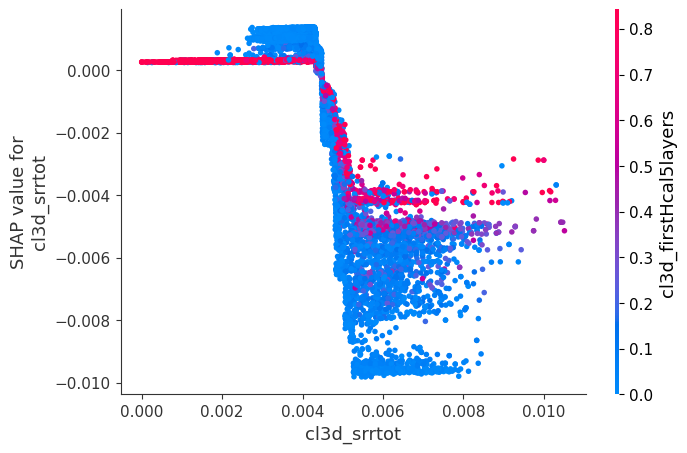

Saved: shap_dependence_cl3d_layer90.png


<Figure size 640x480 with 0 Axes>

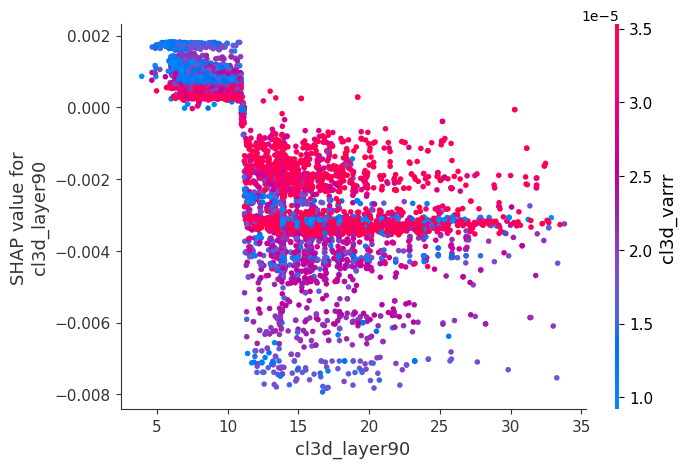

Saved: shap_dependence_cl3d_emax3layers.png


<Figure size 640x480 with 0 Axes>

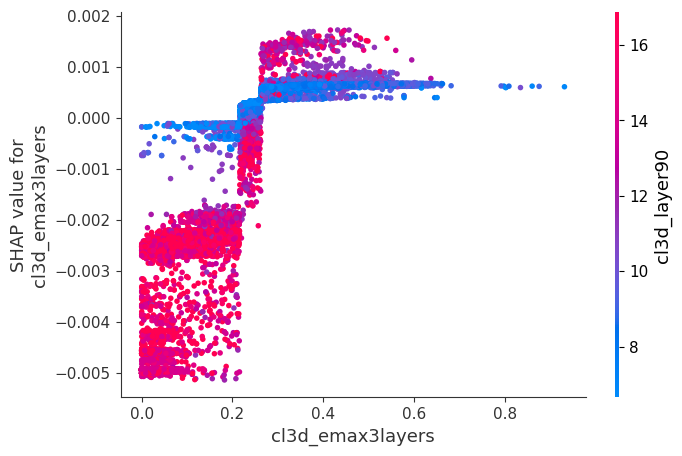

In [88]:
# Generate SHAP dependence plots for the top three features
# Sort features by their mean absolute SHAP values and pick the top three.
sorted_features = sorted(mean_shap_values, key=mean_shap_values.get, reverse=True)
for feature in sorted_features[:3]:
    plt.figure()
    shap.dependence_plot(feature, shap_values.values, X_test, show=False)
    filename = f"shap_dependence_{feature}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()

In [89]:
'''
for pt_bin in range(len(pt_bins) - 1):  
    print(f"Optimizing for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")

    bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
    X = bin_data[columns_for_training]
    y = bin_data['label']

    # Check class balance
    class_counts = y.value_counts()
    if len(class_counts) < 2:  
        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
        continue

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100, n_jobs=1)  # Reduce trials for efficiency

    print(f"Best parameters for pT bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}: {study.best_params}")

    # Train final model with best parameters
    best_params = study.best_params
    best_params.update({"n_jobs": 20})  
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)

    # SHAP analysis
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)
    shap_values_by_bin[pt_bin] = shap_values

    # Compute Mean Absolute SHAP Value for each feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Store feature importance
    for feature, shap_mean in zip(columns_for_training, mean_abs_shap):
        if feature not in mean_shap_values:
            mean_shap_values[feature] = []
        mean_shap_values[feature].append(shap_mean)

    # Generate SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Summary for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    filename = f"{pt_bins[pt_bin]}_shap_summary_20GeV.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()

    # Generate SHAP dependence plots for the top features
    for feature in columns_for_training[:3]:  
        plt.figure()
        shap.dependence_plot(feature, shap_values.values, X_test, show=False)
        filename = f"{pt_bins[pt_bin]}_shap_dependence_{feature}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
'''

'\nfor pt_bin in range(len(pt_bins) - 1):  \n    print(f"Optimizing for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")\n\n    bin_data = filtered_data[filtered_data[\'pt_bin\'] == pt_bin]\n    X = bin_data[columns_for_training]\n    y = bin_data[\'label\']\n\n    # Check class balance\n    class_counts = y.value_counts()\n    if len(class_counts) < 2:  \n        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")\n        continue\n\n    # Train-test split\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\n    # Optuna hyperparameter tuning\n    study = optuna.create_study(direction="maximize")\n    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100, n_jobs=1)  # Reduce trials for efficiency\n\n    print(f"Best parameters for pT bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}: {study.best_params}")\n\n    # Train final model with best parameters

In [90]:
def quantize_feature(series, n_mantissa_bits, value_range=None):
    # Determine the range if not provided.
    if value_range is None:
        min_val, max_val = series.min(), series.max()
    else:
        min_val, max_val = value_range

    n_levels = 2 ** n_mantissa_bits
    normalized = (series - min_val) / (max_val - min_val)
    
    # Quantize: multiply by number of levels, floor it to truncate,
    # then divide back by number of levels and rescale.
    quantized = np.floor(normalized * n_levels) / n_levels
    quantized = quantized * (max_val - min_val) + min_val
    
    return quantized

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 97%|=================== | 22189/22898 [00:12<00:00]       

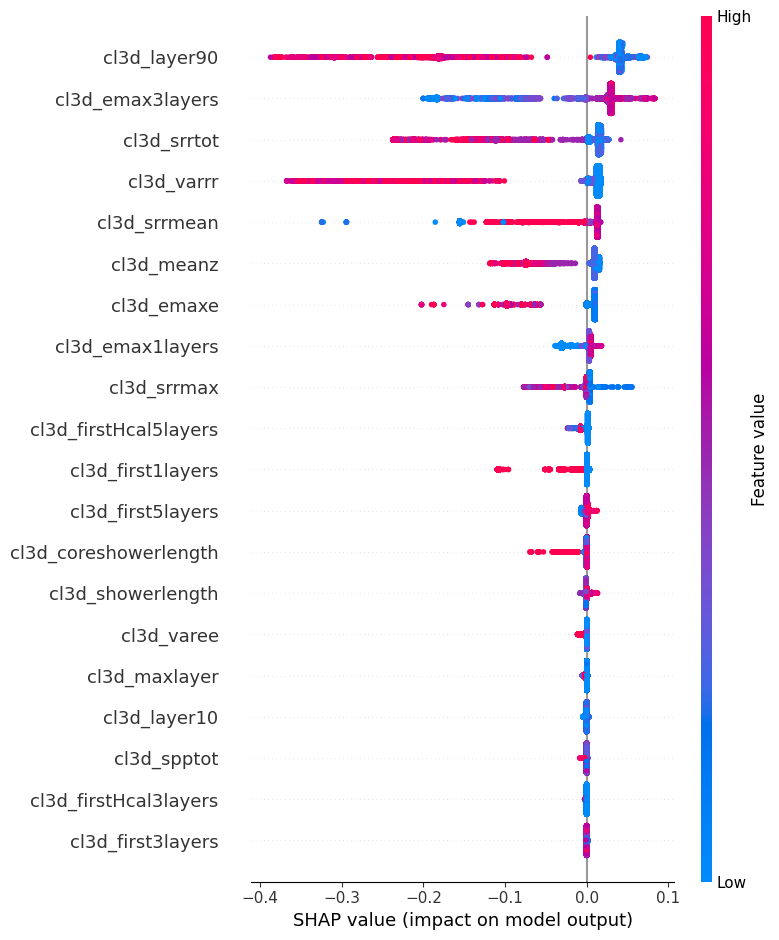

In [80]:
most_important_features = list(mean_shap_values.keys())[:10]
n_mantissa_bits = 4

quantized_data = filtered_data.copy()
for feature in columns_for_training:
    quantized_data[feature] = quantize_feature(quantized_data[feature], n_mantissa_bits)

X_quantized = quantized_data[columns_for_training]
y_quantized = quantized_data['label']
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X_quantized, y_quantized, test_size=0.2, random_state=42)

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_q, y_train_q)
explainer = shap.Explainer(best_model, X_train_q)
shap_values = explainer(X_test_q)
shap.summary_plot(shap_values, X_test_q)
plt.show()

ROC AUC: 0.9909


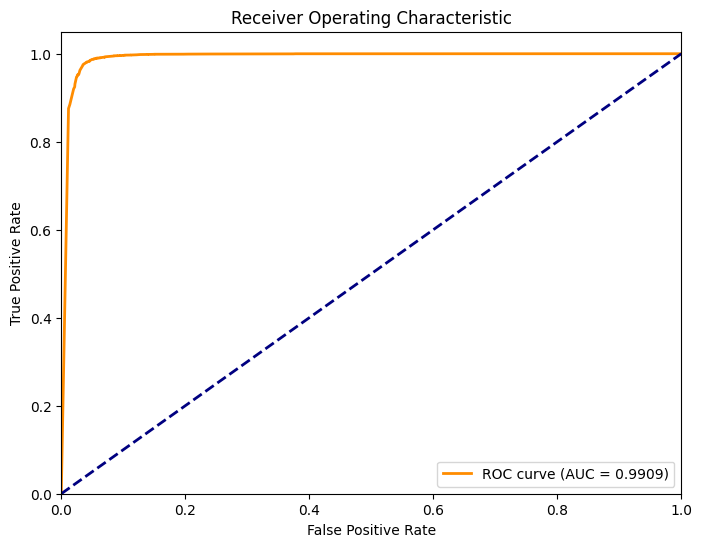

In [81]:
# --- ROC Curve Plotting ---

# Obtain predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test_q)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_q, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [41]:
print(list(mean_shap_values.keys())[:10])

['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot']


# 